# Question 1

In [128]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.initializers import RandomNormal
from tensorflow.keras import initializers


In [129]:
mnist = tf.keras.datasets.mnist

In [130]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

x_train, x_test = x_train / 255.0, x_test / 255.0

In [131]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [132]:
Baseline = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(1024, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(1024, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(1024, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(1024, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(1024, activation="relu", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.Dense(10, activation="softmax")

])
loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]
Baseline.compile(loss=loss , optimizer=opt, metrics=metrics)

In [133]:
Baseline_model=Baseline.fit(x_train, y_train, batch_size=500, epochs=50,validation_data=(x_test,y_test))

Epoch 1/50
120/120 [==============================] - 8s 55ms/step - loss: 0.3208 - accuracy: 0.9038 - val_loss: 0.1003 - val_accuracy: 0.9686
Epoch 2/50
120/120 [==============================] - 7s 55ms/step - loss: 0.0765 - accuracy: 0.9762 - val_loss: 0.0793 - val_accuracy: 0.9748
Epoch 3/50
120/120 [==============================] - 7s 55ms/step - loss: 0.0469 - accuracy: 0.9850 - val_loss: 0.0739 - val_accuracy: 0.9785
Epoch 4/50
120/120 [==============================] - 7s 57ms/step - loss: 0.0329 - accuracy: 0.9893 - val_loss: 0.0741 - val_accuracy: 0.9780
Epoch 5/50
120/120 [==============================] - 6s 54ms/step - loss: 0.0274 - accuracy: 0.9913 - val_loss: 0.0818 - val_accuracy: 0.9781
Epoch 6/50
120/120 [==============================] - 7s 55ms/step - loss: 0.0250 - accuracy: 0.9922 - val_loss: 0.0846 - val_accuracy: 0.9789
Epoch 7/50
120/120 [==============================] - 7s 58ms/step - loss: 0.0232 - accuracy: 0.9923 - val_loss: 0.1010 - val_accuracy: 0.9758

In [134]:
weight_matrix = [Baseline.layers[i].get_weights()[0] for i in range(1,len(Baseline.layers)-1)]
bias_matrix = [Baseline.layers[i].get_weights()[1] for i in range(1,len(Baseline.layers)-1)]

In [135]:
w_matrix = [Baseline.layers[i].get_weights()[0] for i in range(1,len(Baseline.layers))]
b_matrix = [Baseline.layers[i].get_weights()[1] for i in range(1,len(Baseline.layers))]

In [136]:
def apply_svd(layer,k,j):
    if isinstance(layer, tf.keras.layers.Dense):
        weights, biases = weight_matrix[j],bias_matrix[j]
        s, u, v = tf.linalg.svd(weights)
        u = u[:, :k]
        s = s[:k]
        v = v[:, :k]
        new_weights = tf.matmul(u, tf.matmul(tf.linalg.diag(s), tf.transpose(v)))
        layer.set_weights([new_weights, biases])

In [137]:
accuracy =[]
baseline_params = sum([tf.reduce_prod(var.shape) for var in Baseline.trainable_variables])
D_values = [10, 20, 50, 100, 200, 1024]
param = []
param_ratio = []
for j in range(6):
    svded_params = 0
    for i in range(1,len(Baseline.layers) - 1):
        apply_svd(Baseline.layers[i],D_values[j],i-1)
        layer = Baseline.layers[i]
        weights, _ = layer.get_weights()
        svded_params += weights.shape[0] * D_values[j] + D_values[j] 
    param.append(svded_params)
    param_ratio.append(baseline_params / svded_params)
    print(f"Number of parameters in SVDed model (D={D_values[j]}):", svded_params)
    print(f"Parameter reduction ratio compared to baseline (D={D_values[j]}): {baseline_params / svded_params:.2f}")

    accuracy.append(Baseline.evaluate(x_test,y_test))

Number of parameters in SVDed model (D=10): 48850
Parameter reduction ratio compared to baseline (D=10): 102.61
313/313 [==============================] - 2s 6ms/step - loss: 1.5608 - accuracy: 0.7062
Number of parameters in SVDed model (D=20): 97700
Parameter reduction ratio compared to baseline (D=20): 51.30
313/313 [==============================] - 2s 6ms/step - loss: 0.3329 - accuracy: 0.9202
Number of parameters in SVDed model (D=50): 244250
Parameter reduction ratio compared to baseline (D=50): 20.52
313/313 [==============================] - 2s 6ms/step - loss: 0.1122 - accuracy: 0.9796
Number of parameters in SVDed model (D=100): 488500
Parameter reduction ratio compared to baseline (D=100): 10.26
313/313 [==============================] - 2s 6ms/step - loss: 0.0981 - accuracy: 0.9829
Number of parameters in SVDed model (D=200): 977000
Parameter reduction ratio compared to baseline (D=200): 5.13
313/313 [==============================] - 2s 6ms/step - loss: 0.1000 - accuracy: 

In [138]:
l=[]
for i in range(6):
    l.append(accuracy[i][1])

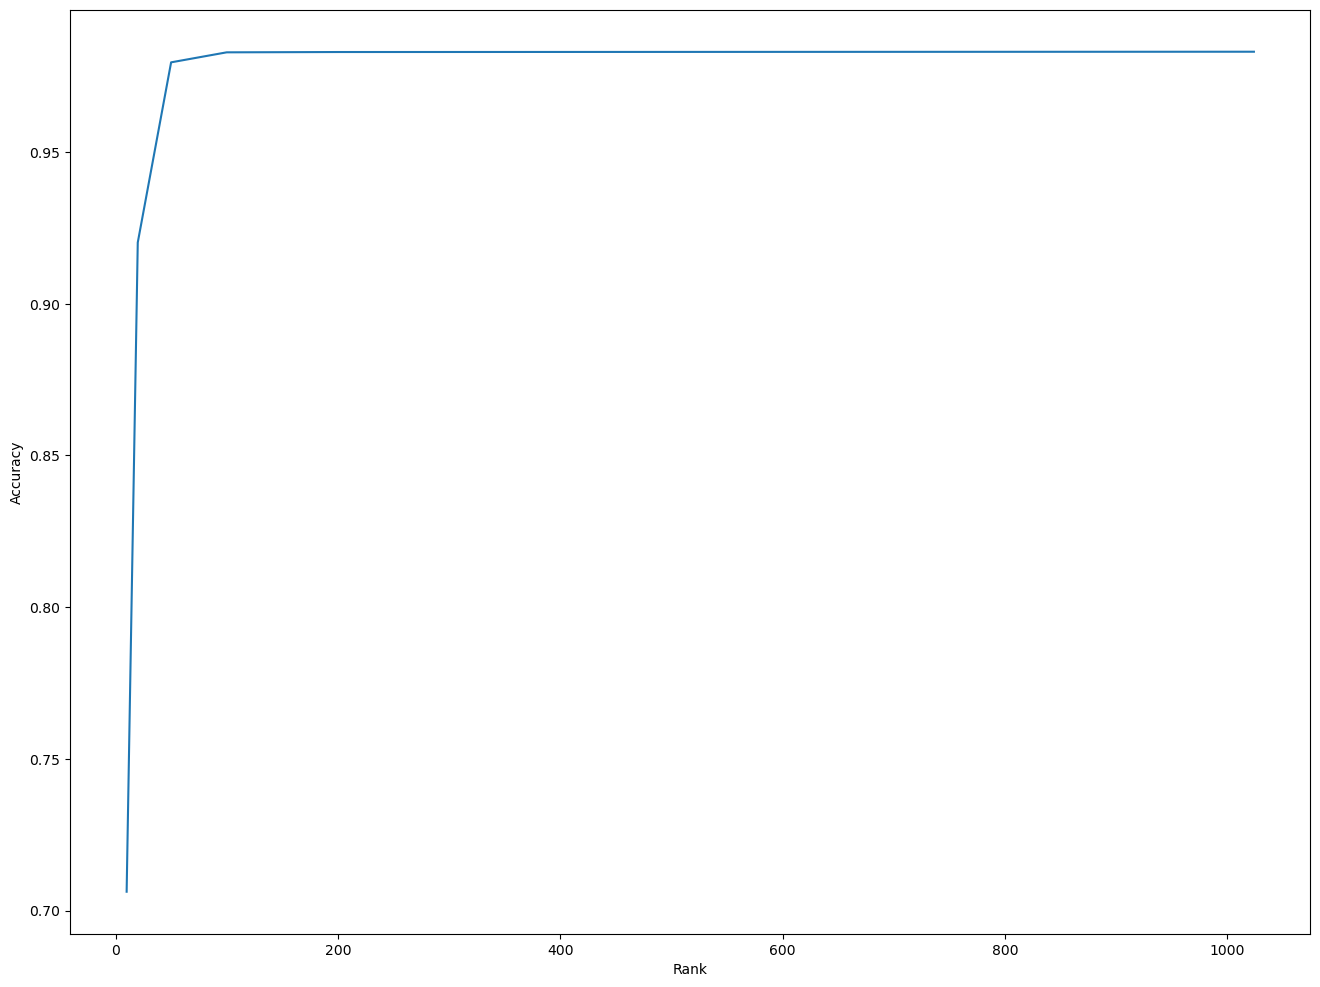

In [139]:
plt.figure(figsize=(16,12))
custom_ticks = [10, 20, 50, 100, 200, 1024]
plt.plot(custom_ticks,l)
plt.xlabel("Rank")
plt.ylabel("Accuracy")
plt.show()


# Question 2

In [75]:
SVDNetwork = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28))
])

In [76]:
def custom_initializer(u, s, v):
    def initialize_weights(shape, dtype=None):
        return tf.matmul(u, tf.matmul(tf.linalg.diag(s), tf.transpose(v)))
    return initialize_weights

In [77]:
def apply_svd(layer, k, j):
    weights, biases = weight_matrix[j], bias_matrix[j]
    u, s, v = np.linalg.svd(weights)
    u = u[:, :k]
    s = s[:k]
    v = v[:, :k]
    v = np.matmul(np.diag(s[:20]), v[:, :20].T) # Transpose V_D
    custom_weights_initializer = custom_initializer(u, s, v)
    SVDNetwork.add(tf.keras.layers.Dense(20,use_bias = False, weights = [u]))
    SVDNetwork.add(tf.keras.layers.Dense(1024, activation='relu', weights = [v,biases]))


In [78]:
for i in range(1, len(Baseline.layers) - 1):
    apply_svd(Baseline.layers[i],20, i-1)
    layer = SVDNetwork.layers[i]

In [79]:
SVDNetwork.add(tf.keras.layers.Dense(10, activation="softmax"))


In [80]:
SVDNetwork.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_53 (Dense)            (None, 20)                15680     
                                                                 
 dense_54 (Dense)            (None, 1024)              21504     
                                                                 
 dense_55 (Dense)            (None, 20)                20480     
                                                                 
 dense_56 (Dense)            (None, 1024)              21504     
                                                                 
 dense_57 (Dense)            (None, 20)                20480     
                                                                 
 dense_58 (Dense)            (None, 1024)            

In [81]:
loss = tf.keras.losses.CategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
metrics = ["accuracy"]
SVDNetwork.compile(loss=loss, optimizer=opt, metrics=metrics)

In [82]:
SVDNetwork_history=SVDNetwork.fit(x_train, y_train, batch_size=500, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
120/120 [==============================] - 5s 26ms/step - loss: 257.3396 - accuracy: 0.1023 - val_loss: 2.4309 - val_accuracy: 0.0952
Epoch 2/50
120/120 [==============================] - 3s 21ms/step - loss: 2.3094 - accuracy: 0.1201 - val_loss: 2.2655 - val_accuracy: 0.1030
Epoch 3/50
120/120 [==============================] - 3s 22ms/step - loss: 2.1940 - accuracy: 0.1992 - val_loss: 2.0427 - val_accuracy: 0.3848
Epoch 4/50
120/120 [==============================] - 3s 22ms/step - loss: 1.8237 - accuracy: 0.3758 - val_loss: 1.4814 - val_accuracy: 0.4670
Epoch 5/50
120/120 [==============================] - 3s 23ms/step - loss: 1.3195 - accuracy: 0.5342 - val_loss: 1.1307 - val_accuracy: 0.6121
Epoch 6/50
120/120 [==============================] - 3s 24ms/step - loss: 0.9577 - accuracy: 0.6896 - val_loss: 0.7416 - val_accuracy: 0.7868
Epoch 7/50
120/120 [==============================] - 3s 24ms/step - loss: 0.6535 - accuracy: 0.8029 - val_loss: 0.5504 - val_accuracy: 0.84

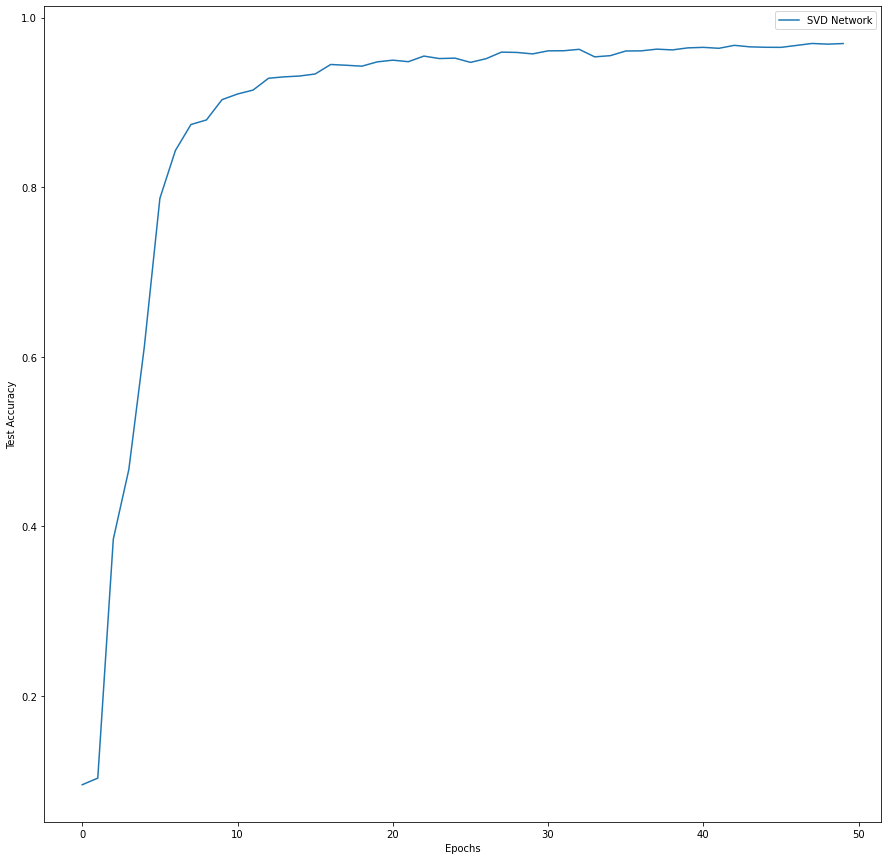

In [85]:
fig = plt.figure(figsize=(15,15))
plt.plot(SVDNetwork_history.history["val_accuracy"],label = "SVD Network")
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

# Question 3

In [20]:
@tf.custom_gradient
def weight_update(w):
    s,u,v=tf.linalg.svd(w,compute_uv=True,full_matrices=True)
    u = u[:, :20]
    s = s[:20]
    v = v[:, :20]
    wt = tf.matmul(u, tf.matmul(tf.linalg.diag(s), tf.transpose(v)))
    def grad_temp(dy):
        return dy
    return wt, grad_temp

class CustSVDLayer(tf.keras.layers.Layer):
    def __init__(self,units,weights):
      super(CustSVDLayer, self).__init__()
      self.units=units
      self.activation=tf.keras.activations.get("relu")
      self.w=tf.Variable(
            initial_value=weights[0],
            trainable=True,
        )
      self.b=tf.Variable(
            initial_value=weights[1],
            trainable=True,
        )
    def call(self, inputs):
        w1=weight_update(self.w)  
        a=self.activation(tf.matmul(inputs,w1)+self.b)
        return a

In [21]:
model_3=tf.keras.Sequential(
    [     tf.keras.layers.Flatten(input_shape=(28,28,1)),
     CustSVDLayer(units=1024,weights=[weight_matrix[0],bias_matrix[0]]),
     CustSVDLayer(units=1024,weights=[weight_matrix[1],bias_matrix[1]]),
     CustSVDLayer(units=1024,weights=[weight_matrix[2],bias_matrix[2]]),
     CustSVDLayer(units=1024,weights=[weight_matrix[3],bias_matrix[3]]),
     CustSVDLayer(units=1024,weights=[weight_matrix[4],bias_matrix[4]]),
     tf.keras.layers.Dense(units=10,input_shape=(1024,),activation='softmax',name='last_layer',weights=[w_matrix[5],b_matrix[5]])
    ]
)


In [22]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(),loss='categorical_crossentropy',metrics=['accuracy'])
model3h=model_3.fit(x_train, y_train, shuffle=True,batch_size=128 ,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
469/469 [==============================] - 388s 825ms/step - loss: 0.0215 - accuracy: 0.9697 - val_loss: 0.0198 - val_accuracy: 0.9695
Epoch 2/10
469/469 [==============================] - 387s 826ms/step - loss: 0.0150 - accuracy: 0.9754 - val_loss: 0.0190 - val_accuracy: 0.9707
Epoch 3/10
469/469 [==============================] - 385s 820ms/step - loss: 0.0136 - accuracy: 0.9780 - val_loss: 0.0183 - val_accuracy: 0.9724
Epoch 4/10
469/469 [==============================] - 385s 821ms/step - loss: 0.0122 - accuracy: 0.9797 - val_loss: 0.0176 - val_accuracy: 0.9731
Epoch 5/10
469/469 [==============================] - 384s 820ms/step - loss: 0.0117 - accuracy: 0.9807 - val_loss: 0.0153 - val_accuracy: 0.9755
Epoch 6/10
469/469 [==============================] - 383s 816ms/step - loss: 0.0111 - accuracy: 0.9812 - val_loss: 0.0164 - val_accuracy: 0.9770
Epoch 7/10
469/469 [==============================] - 387s 826ms/step - loss: 0.0107 - accuracy: 0.9830 - val_loss: 0.0166 -

# Question 4

In [113]:
import pickle
with open('trs.pkl', 'rb') as file:
    train_data = pickle.load(file)
with open('tes.pkl', 'rb') as file:
    test_data = pickle.load(file)

In [114]:
import random
def generate_sample_positive_indices(start,end):
    temp = range(start,end)
    indices = []
    while len(indices) != 45:
        temp_index=random.sample(temp,2)
        ti=[0,0]
        ti[1],ti[0] = temp_index[0],temp_index[1]
        if ti not in indices and temp_index not in indices:
            indices.append(temp_index)
    return indices
def generate_sample_negative_indices(start,size,samp):
    temp = range(start,start+10)
    indices=[]
    i=0
    while len(indices)!=samp:
        while i<size:
            # print(i not in temp)
            if i not in temp:
                xy=range(i,i+10)
                tempa =[random.sample(temp,1)[0],random.sample(xy,1)[0]]
                ti=[0,0]
                ti[1],ti[0] = tempa[0],tempa[1]
                if ti not in indices and tempa not in indices:
                    indices.append(tempa)
                    len(indices)
                    break
            else:
                break
        i=i+10
    return indices

In [115]:
y=[]
left=[]
right=[]
for x in range(0,500,10):
    positive=generate_sample_positive_indices(x,x+10)
    negative=random.sample(generate_sample_negative_indices(x,500,49),45)
    for i in positive:
        left.append(train_data[i[0]])
        right.append(train_data[i[1]])
        y.append(1)
    for j in negative:
        left.append(train_data[j[0]])
        right.append(train_data[j[1]])
        y.append(0)
print(np.array(left).shape)
print(np.array(right).shape)
print(np.array(y).shape)

(4500, 16180)
(4500, 16180)
(4500,)


In [116]:
import librosa
def preprocess_sound(sound):
    processed_sound=np.abs(librosa.stft(np.array(sound), n_fft=1024, hop_length=512))
    return(processed_sound)


In [117]:
S_L_Train=[]
S_R_Train=[]
for l in left:
    S_L_Train.append(preprocess_sound(l))
for r in right:
    S_R_Train.append(preprocess_sound(r))
S_L_Train=np.array(S_L_Train).transpose(0,2,1)
S_R_Train=np.array(S_R_Train).transpose(0,2,1)

In [118]:
y_test=[]
left_test=[]
right_test=[]
for x in range(0,200,10):
    positive=random.sample(generate_sample_positive_indices(x,x+10),19)
    negative=random.sample(generate_sample_negative_indices(x,200,19),19)
    for i in positive:
        left_test.append(test_data[i[0]])
        right_test.append(test_data[i[1]])
        y_test.append(1)
    for j in negative:
        left_test.append(test_data[j[0]])
        right_test.append(test_data[j[1]])
        y_test.append(0)
print(np.array(left_test).shape)
print(np.array(right_test).shape)
print(np.array(y_test).shape)

(760, 22631)
(760, 22631)
(760,)


In [119]:
S_L_Test=[]
S_R_Test=[]
for l in left_test:
    S_L_Test.append(preprocess_sound(l))
for r in right_test:
    S_R_Test.append(preprocess_sound(r))
S_L_Test=np.array(S_L_Test).transpose(0,2,1)
S_R_Test=np.array(S_R_Test).transpose(0,2,1)


In [120]:
left_input = tf.keras.layers.Input(shape=(None,513))
right_input = tf.keras.layers.Input(shape=(None,513))
siaml = tf.keras.Sequential()
siaml.add(tf.keras.layers.GRU(activation='tanh',units=512))
siaml.add(tf.keras.layers.GRU(activation='tanh',units=512))
siamr = tf.keras.Sequential()
siamr.add(tf.keras.layers.GRU(activation='tanh',units=512))
siamr.add(tf.keras.layers.GRU(activation='tanh',units=512))
encoded_l = siaml(left_input)
encoded_r = siamr(right_input)

In [121]:
L1_layer = tf.keras.layers.Lambda(lambda tensors:tf.reduce_sum( tf.multiply( tensors[0], tensors[1] ), 1 ))

In [123]:
siamese_net = tf.keras.Model(inputs=[left_input,right_input],outputs= tf.keras.layers.Dense(1,activation='sigmoid')(L1_layer([encoded_l, encoded_r])))
siamese_net.compile(loss=tf.keras.losses.BinaryCrossentropy() , optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001), metrics= ["accuracy"])

In [126]:
siamh= siamese_net.fit([S_L_Train,S_R_Train],np.array(y),batch_size=50, epochs=200,shuffle=True, validation_data=([S_L_Test,S_R_Test],np.array(y_test)),validation_batch_size=50)

Epoch 1/200
90/90 [==============================] - 51s 539ms/step - loss: 0.7325 - accuracy: 0.5060 - val_loss: 0.7289 - val_accuracy: 0.5092
Epoch 2/200
90/90 [==============================] - 45s 498ms/step - loss: 0.7174 - accuracy: 0.5091 - val_loss: 0.7161 - val_accuracy: 0.5158
Epoch 3/200
90/90 [==============================] - 45s 496ms/step - loss: 0.7071 - accuracy: 0.5200 - val_loss: 0.7070 - val_accuracy: 0.5289
Epoch 4/200
90/90 [==============================] - 45s 497ms/step - loss: 0.6985 - accuracy: 0.5316 - val_loss: 0.6963 - val_accuracy: 0.5250
Epoch 5/200
90/90 [==============================] - 45s 496ms/step - loss: 0.6911 - accuracy: 0.5416 - val_loss: 0.6891 - val_accuracy: 0.5421
Epoch 6/200
90/90 [==============================] - 46s 509ms/step - loss: 0.6845 - accuracy: 0.5496 - val_loss: 0.6843 - val_accuracy: 0.5487
Epoch 7/200
90/90 [==============================] - 45s 500ms/step - loss: 0.6788 - accuracy: 0.5636 - val_loss: 0.6778 - val_accuracy:

90/90 [==============================] - 43s 478ms/step - loss: 0.3952 - accuracy: 0.8471 - val_loss: 0.5594 - val_accuracy: 0.7000
Epoch 114/200
90/90 [==============================] - 43s 479ms/step - loss: 0.3934 - accuracy: 0.8484 - val_loss: 0.5496 - val_accuracy: 0.7079
Epoch 115/200
90/90 [==============================] - 43s 478ms/step - loss: 0.3917 - accuracy: 0.8487 - val_loss: 0.5495 - val_accuracy: 0.7079
Epoch 116/200
90/90 [==============================] - 43s 478ms/step - loss: 0.3901 - accuracy: 0.8511 - val_loss: 0.5532 - val_accuracy: 0.7053
Epoch 117/200
90/90 [==============================] - 43s 477ms/step - loss: 0.3884 - accuracy: 0.8504 - val_loss: 0.5617 - val_accuracy: 0.7026
Epoch 118/200
90/90 [==============================] - 43s 479ms/step - loss: 0.3869 - accuracy: 0.8516 - val_loss: 0.5549 - val_accuracy: 0.7066
Epoch 119/200
90/90 [==============================] - 43s 477ms/step - loss: 0.3852 - accuracy: 0.8529 - val_loss: 0.5484 - val_accuracy:

# Question 5

In [1]:
import librosa
import os
import numpy as np
import tensorflow as tf

In [2]:
def pad_audio(audio):
    padding = np.zeros((195 - len(audio), 513))
    padded_audio = np.concatenate((audio, padding), axis=0)
    return padded_audio

In [3]:
def load_and_process_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    magnitude = np.abs(stft)
    return magnitude.T

In [4]:
clean_speech =[]
noise =[]
noisy_speech =[]
directory = "C:/Users/dassu/Downloads/timit-homework/tr/"

In [5]:
for filename in os.listdir(directory):
    if filename.startswith('trs') and filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        spectrogram = load_and_process_audio(file_path)
        spectrogram=pad_audio(spectrogram)
        clean_speech.append(spectrogram)
clean_speech= np.array(clean_speech)

In [6]:
for filename in os.listdir(directory):
    if filename.startswith('trx') and filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        spectrogram = load_and_process_audio(file_path)
        spectrogram=pad_audio(spectrogram)
        noisy_speech.append(spectrogram)
noisy_speech = np.array(noisy_speech)

In [7]:
for filename in os.listdir(directory):
    if filename.startswith('trn') and filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        spectrogram = load_and_process_audio(file_path)
        spectrogram=pad_audio(spectrogram)
        noise.append(spectrogram)
noise = np.array(noise)

In [8]:
IBM = np.where(clean_speech > noise, 1, 0)

In [9]:
def process_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    magnitude = np.abs(stft)
    return magnitude.T,stft,magnitude

In [10]:
valid_noisy_speech=[]
directory2 = "C:/Users/dassu/Downloads/timit-homework/v/"
for filename in os.listdir(directory2):
    if filename.startswith('vx') and filename.endswith('.wav'):
        file_path = os.path.join(directory2, filename)
        spectrogram,stf,mag = process_audio(file_path)
        spectrogram=pad_audio(spectrogram)
        valid_noisy_speech.append(spectrogram)
valid_noisy_speech= np.array(valid_noisy_speech)

In [11]:
valid_clean_speech=[]
for filename in os.listdir(directory2):
    if filename.startswith('vs') and filename.endswith('.wav'):
        file_path = os.path.join(directory2, filename)
        spectrogram,_,_ = process_audio(file_path)
        spectrogram=pad_audio(spectrogram)
        valid_clean_speech.append(spectrogram)
valid_clean_speech = np.array(valid_clean_speech)

In [12]:
valid_noise=[]
for filename in os.listdir(directory2):
    if filename.startswith('vn') and filename.endswith('.wav'):
        file_path = os.path.join(directory2, filename)
        spectrogram,_,_ = process_audio(file_path)
        spectrogram=pad_audio(spectrogram)
        valid_noise.append(spectrogram)
valid_noise = np.array(valid_noise)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(513, return_sequences=True, input_shape=( 195,513)),
    tf.keras.layers.LSTM(513,return_sequences =True),
    tf.keras.layers.Dense(513,activation = "sigmoid")
])

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
IBM_validation = np.where(valid_clean_speech > valid_noise, 1, 0)

In [16]:
# Training
model.fit(noisy_speech,IBM, epochs=100,validation_data=(valid_noisy_speech,IBM_validation), batch_size=20)

Epoch 1/100
60/60 [==============================] - 97s 2s/step - loss: 0.4411 - val_loss: 0.3673
Epoch 2/100
60/60 [==============================] - 95s 2s/step - loss: 0.3534 - val_loss: 0.3384
Epoch 3/100
60/60 [==============================] - 95s 2s/step - loss: 0.3249 - val_loss: 0.3017
Epoch 4/100
60/60 [==============================] - 95s 2s/step - loss: 0.2971 - val_loss: 0.2805
Epoch 5/100
60/60 [==============================] - 90s 1s/step - loss: 0.2794 - val_loss: 0.2751
Epoch 6/100
60/60 [==============================] - 86s 1s/step - loss: 0.2703 - val_loss: 0.2724
Epoch 7/100
60/60 [==============================] - 86s 1s/step - loss: 0.3055 - val_loss: 0.2831
Epoch 8/100
60/60 [==============================] - 86s 1s/step - loss: 0.2663 - val_loss: 0.2599
Epoch 9/100
60/60 [==============================] - 88s 1s/step - loss: 0.2512 - val_loss: 0.2497
Epoch 10/100
60/60 [==============================] - 84s 1s/step - loss: 0.2441 - val_loss: 0.2422
Epoch 11/

60/60 [==============================] - 83s 1s/step - loss: 0.1541 - val_loss: 0.1983
Epoch 84/100
60/60 [==============================] - 84s 1s/step - loss: 0.1530 - val_loss: 0.1961
Epoch 85/100
60/60 [==============================] - 83s 1s/step - loss: 0.1523 - val_loss: 0.1972
Epoch 86/100
60/60 [==============================] - 84s 1s/step - loss: 0.1525 - val_loss: 0.1991
Epoch 87/100
60/60 [==============================] - 84s 1s/step - loss: 0.1525 - val_loss: 0.1986
Epoch 88/100
60/60 [==============================] - 83s 1s/step - loss: 0.1511 - val_loss: 0.1963
Epoch 89/100
60/60 [==============================] - 83s 1s/step - loss: 0.1502 - val_loss: 0.1991
Epoch 90/100
60/60 [==============================] - 85s 1s/step - loss: 0.1498 - val_loss: 0.1994
Epoch 91/100
60/60 [==============================] - 86s 1s/step - loss: 0.1504 - val_loss: 0.1968
Epoch 92/100
60/60 [==============================] - 86s 1s/step - loss: 0.1496 - val_loss: 0.1974
Epoch 93/100


In [37]:
recon = model.predict(valid_noisy_speech)

38/38 [==============================] - 26s 675ms/step


In [38]:
def process_audio_stft(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    magnitude = np.abs(stft)
    return magnitude.T,audio,magnitude

In [39]:
valid_noisy_test=[]
directory2 = "C:/Users/dassu/Downloads/timit-homework/v/"
for filename in os.listdir(directory2):
    if filename.startswith('vx') and filename.endswith('.wav'):
        file_path = os.path.join(directory2, filename)
        _,spectrogram,_ = process_audio(file_path)
        valid_noisy_test.append(spectrogram)

In [40]:
noisy_isft=[]
for i in range(0,len(recon)):
    noisy_signal = recon[i][:len(valid_noisy_test[i][1])] * valid_noisy_test[i].T
    j= librosa.istft(noisy_signal.T, win_length=1024, hop_length=512)
    noisy_isft.append(j)

In [41]:
valid_clean_test=[]
directory2 = "C:/Users/dassu/Downloads/timit-homework/v/"
for filename in os.listdir(directory2):
    if filename.startswith('vs') and filename.endswith('.wav'):
        file_path = os.path.join(directory2, filename)
        _,spectrogram,_ = process_audio_stft(file_path)
        valid_clean_test.append(spectrogram)

In [42]:
def calculate_snr(clean_signal, denoised_signal):
    noise = clean_signal[:len(denoised_signal)] - denoised_signal
    snr = 10 * np.log10(np.sum(clean_signal ** 2) / np.sum(noise ** 2))
    return snr

In [43]:
snr_values = []
for i in range(len(clean_speech)):
    snr = calculate_snr(valid_clean_test[i],noisy_isft[i])
    snr_values.append(snr)

In [44]:
average_snr = np.mean(snr_values)
print(f"Average SNR on validation set: {average_snr} dB")

Average SNR on validation set: 11.185748621324699 dB


In [25]:
def process_audio_test(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    stft = librosa.stft(audio, n_fft=1024, hop_length=512)
    magnitude = np.abs(stft)
    return magnitude.T,stft,magnitude,sr

In [26]:
directory3 = "C:/Users/dassu/Downloads/timit-homework/te/"
valid_test_speech=[]
sample_rate =[]
for filename in os.listdir(directory3):
    if filename.startswith('tex') and filename.endswith('.wav'):
        file_path = os.path.join(directory3, filename)
        spectrogram,_,_,sr = process_audio_test(file_path)
        spectrogram=pad_audio(spectrogram)
        sample_rate.append(sr)
        valid_test_speech.append(spectrogram)
valid_test_speech = np.array(valid_test_speech)

In [27]:
recon = model.predict(valid_test_speech)

13/13 [==============================] - 8s 595ms/step


In [28]:
recon.shape

(400, 195, 513)

In [29]:
valid_test_speech=[]
directory3 = "C:/Users/dassu/Downloads/timit-homework/te/"
for filename in os.listdir(directory3):
    if filename.startswith('tex') and filename.endswith('.wav'):
        file_path = os.path.join(directory3, filename)
        _,spectrogram,_,_ = process_audio_test(file_path)
        valid_test_speech.append(spectrogram)

In [30]:
test_isft=[]
for i in range(0,len(recon)):
    test_signal = recon[i][:len(valid_test_speech[i][1])] * (valid_test_speech[i]).T
    j= librosa.istft(test_signal.T, win_length=1024, hop_length=512)
    test_isft.append(j)

In [31]:
import soundfile as sf

In [32]:
text="test_hw4_recons"
wav =".wav"
for i in range(0,len(test_isft)):
    sf.write("C:/Users/dassu/Downloads/timit-homework/reconstructed/"+text+str(i)+wav, test_isft[i],16000)